In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime  
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
%matplotlib inline

## load and check data
data_df = None

if os.path.isfile('../data/train.csv'):
    data_df = pd.read_csv('../data/train.csv')
    print('train.csv loaded: data_df({0[0]},{0[1]})'.format(data_df.shape))
else:
    print('Error: train.csv not found')

# basic info about data
#print('')
#print(data_df.info())

# no missing values
print('')
print(data_df.isnull().any().describe())

# 10 different labels ranging from 0 to 9
print('')
print('distinct labels ', data_df['label'].unique())

# data are approximately balanced (less often occurs 5, most often 1)
print('')
print(data_df['label'].value_counts())

Using TensorFlow backend.


train.csv loaded: data_df(42000,785)

count       785
unique        1
top       False
freq        785
dtype: object

distinct labels  [1 0 4 7 3 5 8 9 2 6]

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


x_train_valid.shape =  (42000, 784)
y_train_valid_labels.shape =  (42000, 10)
image_size =  784
image_width =  28
image_height =  28
labels_count =  10


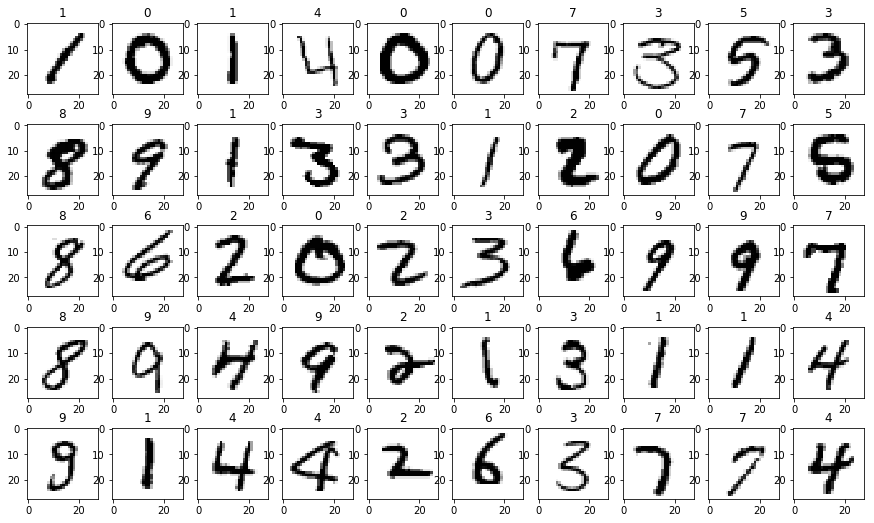

In [2]:
def normalize_data(data):
    data = (data/255)
    return data

# convert class labels from scalars to one-hot vectors e.g. 1 => [0 1 0 0 0 0 0 0 0 0]
def dense_to_one_hot(data_labels, num_classes):
    data_count = data_labels.shape[0]
    index_offset = np.arange(data_count) * num_classes
    data_one_hot = np.zeros((data_count, num_classes))
    data_one_hot.flat[index_offset + data_labels.ravel()] = 1;
    return data_one_hot

# extract and normalize images
x_train_valid = data_df.iloc[:,1:].values.reshape(-1,784) # (42000,784) array
x_train_valid = x_train_valid.astype(np.float) # convert from int64 to float32
x_train_valid = normalize_data(x_train_valid)
image_width = image_height = 28
image_size = 784

# extract image labels
y_train_valid_labels = data_df.iloc[:,0].values # (42000,1) array
labels_count = np.unique(y_train_valid_labels).shape[0]; # number of different labels = 10

#plot some images and labels
plt.figure(figsize=(15,9))
for i in range(50):
    plt.subplot(5,10,1+i)
    plt.title(y_train_valid_labels[i])
    plt.imshow(x_train_valid[i].reshape(28,28), cmap=cm.binary)
    
# labels in one hot representation
y_train_valid = dense_to_one_hot(y_train_valid_labels, labels_count).astype(np.uint8)

# dictionaries for saving results
y_valid_pred = {}
y_train_pred = {}
y_test_pred = {}
train_loss, valid_loss = {}, {}
train_acc, valid_acc = {}, {}

print('x_train_valid.shape = ', x_train_valid.shape)
print('y_train_valid_labels.shape = ', y_train_valid.shape)
print('image_size = ', image_size )
print('image_width = ', image_width)
print('image_height = ', image_height)
print('labels_count = ', labels_count)

In [6]:
class cGANS:
    def __init__(self, cgan_name = "cgan_mnist"):
        self.gW1 = 0
        self.gB1 = 0
        self.gW2 = 0
        self.gB2 = 0
        
        self.dW1 = 0
        self.dB1 = 0
        self.dW2 = 0
        self.dB2 = 0
        
        self.mb_size = 128
        self.batch_start_index = 0
        self.batch_end_index = 0
        self.perm_array = np.array([])
        
        self.z_dim = 100
        self.y_dim = 10
        self.W_dim = 128
        self.X_dim = 784
        
        self.learn_rate = 0.0002
        self.beta1 = 0.5
        
    def get_next_mini_batch(self):
        start = self.batch_start_index
        self.batch_end_index = start + self.mb_size
        
        if start == 0:
            self.perm_array = np.arange(len(self.x_train))
            np.random.shuffle(self.perm_array)
            
        if self.batch_end_index > self.x_train.shape[0]:
            np.random.shuffle(self.perm_array)
            start = 0
            self.batch_end_index = start + self.mb_size
        
        end = self.batch_end_index
        self.batch_start_index += self.mb_size
        
        x_tr = self.x_train[self.perm_array[start:end]]
        y_tr = self.y_train[self.perm_array[start:end]]
        
        return x_tr,y_tr
    
    def weight_init(self, shape):
        xavier_std = tf.sqrt(2 / shape[0])
        wInitial = tf.random_normal(shape=shape, stddev = xavier_std)
        return tf.Variable(wInitial)
    
    def bias_init(self, shape):
        bias = tf.zeros(shape=shape)
        return tf.Variable(bias)
        
    def generator(self, z, y):
        inpt = tf.concat(axis=1, values=[z,y])
        self.gW1 = self.weight_init([self.z_dim + self.y_dim, self.W_dim])
        self.gB1 = self.bias_init([self.W_dim])
        
        gh1 = tf.nn.relu(tf.matmul(inpt, self.gW1) + self.gB1)
        
        self.gW2 = self.weight_init([self.W_dim, self.X_dim])
        self.gB2 = self.bias_init([self.X_dim])
        
        sample = tf.nn.sigmoid(tf.matmul(gh1, self.gW2) + self.gB2)
        
        self.gvar = [self.gW1, self.gB1, self.gW2, self.gB2]
        
        return sample
    
    def discriminator(self, x, y):
        input = tf.concat(axis=1, values=[x,y])
        
        self.dW1 = self.weight_init([self.X_dim + self.y_dim, self.W_dim])
        self.dB1 = self.bias_init([self.W_dim])
        
        dh1 = tf.nn.relu(tf.matmul(input, self.dW1) + self.dB1)
        
        self.dW2 = self.weight_init([self.W_dim, 1])
        self.dB2 = self.bias_init([1])
        
        dlogit = tf.matmul(dh1, self.dW2) + self.dB2
        dprob = tf.nn.sigmoid(dlogit)
        
        self.dvar = [self.dW1, self.dB1, self.dW2, self.dB2]
        
        return dlogit, dprob
    
    def create_graph(self):
        tf.reset_default_graph()

        self.x = tf.placeholder(tf.float32, shape=[None, 784])
        self.y = tf.placeholder(tf.float32, shape=[None, self.y_dim])
        self.z = tf.placeholder(tf.float32, shape=[None, self.z_dim])
        
        self.gSample = self.generator(self.z, self.y)
        
        self.d_real_logits, _ = self.discriminator(self.x, self.y)
        self.d_fake_logits, _ = self.discriminator(self.gSample, self.y)
        
        self.d_real_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.ones_like(self.d_real_logits), logits=self.d_real_logits))
        self.d_fake_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.ones_like(self.d_fake_logits), logits=1-self.d_fake_logits))
        
        self.d_loss = self.d_real_loss + self.d_fake_loss
        
        self.g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.ones_like(self.d_fake_logits), logits=self.d_fake_logits))
        
        self.d_optimizer = tf.train.AdamOptimizer(self.learn_rate).minimize(self.d_loss, var_list=self.dvar)
        self.g_optimizer = tf.train.AdamOptimizer(self.learn_rate).minimize(self.g_loss, var_list=self.gvar)
    
    def sample_Z(self, m, n):
        return np.random.uniform(-1., 1., size=[m, n])

    def train_graph(self, sess, x_train, y_train, n_epoch):
        mb_per_epoch = x_train.shape[0]/self.mb_size
        self.x_train = x_train
        self.y_train = y_train
        
        # start timer
        start = datetime.datetime.now();
        print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')
        print('learnrate = ',self.learn_rate,', n_epoch = ', n_epoch,
              ', mb_size = ', self.mb_size)
        
        for i in range(int(n_epoch*mb_per_epoch)+1):
            x_batch,y_batch = self.get_next_mini_batch()
            Z = self.sample_Z(self.mb_size, self.z_dim)
            sess.run([self.d_optimizer], feed_dict={self.x:x_batch, self.y:y_batch, self.z:Z})
            sess.run([self.g_optimizer], feed_dict={self.x:x_batch, self.y:y_batch, self.z:Z})
    
    def test_graph(self, sess):
        self.mb_size = 16
        Z_sample = self.sample_Z(16, self.z_dim)
        _, y_sample = self.get_next_mini_batch()
        print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start testing')
        samples = sess.run(self.gSample, feed_dict={z: Z_sample, y:y_sample})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        

In [ ]:
cGANgraph = cGANS()
cGANgraph.create_graph()

# input data being read in RAM
#MNIST = input_data.read_data_sets("/data/mnist", one_hot=True)
x_train = x_train_valid
y_train = y_train_valid

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    n_epoch = 100000
    cGANgraph.train_graph(sess, x_train, y_train, n_epoch)
    print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': stop training')
    cGANgraph.test_graph(sess)
    print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': stop testing')

13-03-2019 01:41:22 : start training
learnrate =  0.0002 , n_epoch =  100000 , mb_size =  128
